이 예제는 <<미술관에 gan 딥러닝 실전 프로젝트>> 책에 나온 내용을 정리한 것입니다.

# 모델 만들기

## 데이터 적재

In [1]:
from keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # 범위가 0~255이고 type이 uint인 배열 반환

    x_train = x_train.astype('float32') / 255.               # 범위를 0~1로 맞춰준다.
    x_train = x_train.reshape(x_train.shape + (1,))          # shape을 (60000, 28, 28, 1)로 만들어준다.
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Using TensorFlow backend.


## 신경망 구조 정의

In [0]:
from keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, Activation, Reshape
from keras.models import Model
import numpy as np

# 인코더 모델
encoder_input = Input(shape=(28,28,1), name='encoder_input')
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', name='encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', name='encoder_conv_3')(x)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', name='encoder_conv_4')(x)
x = LeakyReLU()(x)
x = Flatten()(x)
encoder_output= Dense(2, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)

# 디코더 모델
shape_before_flattening = encoder.layers[-3].output_shape[1:]
        
decoder_input = Input(shape=(2,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same', name='decoder_cov_t_1')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', name='decoder_cov_t_2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', name='decoder_cov_t_3')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='decoder_cov_t_4')(x)
decoder_output = Activation('sigmoid')(x)
decoder = Model(decoder_input, decoder_output)

### THE FULL AUTOENCODER
model_output = decoder(encoder_output)
model = Model(encoder_input, model_output)

## 오토인코더 훈련

손실함수는 RMSE로 한다. 'binary_crossentropy'로 해도 된다.


In [5]:
from keras.optimizers import Adam
import keras.backend as K

def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return r_loss

learning_rate = 0.0005

model.compile(optimizer=Adam(lr=learning_rate), 
              loss=vae_r_loss # loss='binary_crossentropy'
)
model.fit(x_train[:5000], x_train[:5000],
          batch_size=128, 
          epochs = 50,
          shuffle = True
)

Epoch 1/50
5000/5000 [==============================] - 1s 235us/step - loss: 0.0505
Epoch 2/50
5000/5000 [==============================] - 1s 163us/step - loss: 0.0500
Epoch 3/50
5000/5000 [==============================] - 1s 159us/step - loss: 0.0496
Epoch 4/50
5000/5000 [==============================] - 1s 159us/step - loss: 0.0493
Epoch 5/50
5000/5000 [==============================] - 1s 160us/step - loss: 0.0489
Epoch 6/50
5000/5000 [==============================] - 1s 163us/step - loss: 0.0485
Epoch 7/50
5000/5000 [==============================] - 1s 158us/step - loss: 0.0482
Epoch 8/50
5000/5000 [==============================] - 1s 161us/step - loss: 0.0480
Epoch 9/50
5000/5000 [==============================] - 1s 159us/step - loss: 0.0478
Epoch 10/50
5000/5000 [==============================] - 1s 160us/step - loss: 0.0479
Epoch 11/50
5000/5000 [==============================] - 1s 161us/step - loss: 0.0474
Epoch 12/50
5000/5000 [==============================] - 1s 159

# 모델 들여다보기

## 재구성 성능 확인

실제 이미지, 인코딩된 값, 재구성된 이미지를 보여준다.

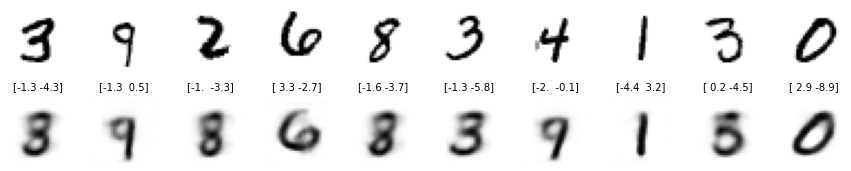

In [6]:
import numpy as np
import matplotlib.pyplot as plt

n_to_show = 10
np.random.seed(88)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = encoder.predict(example_images)

reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

## 숫자에 색깔을 입힌 잠재 공간 산점도

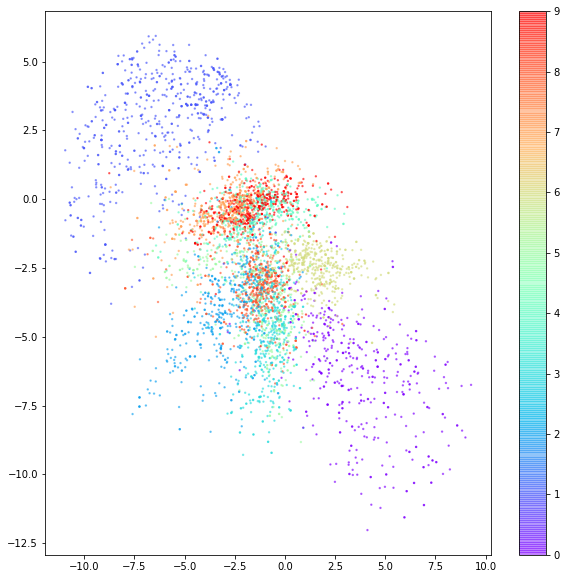

In [7]:
n_to_show = 5000
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=example_labels, alpha=0.5, s=2)
plt.colorbar()
plt.show()

## 임의의 점에서 이미지 생성하기

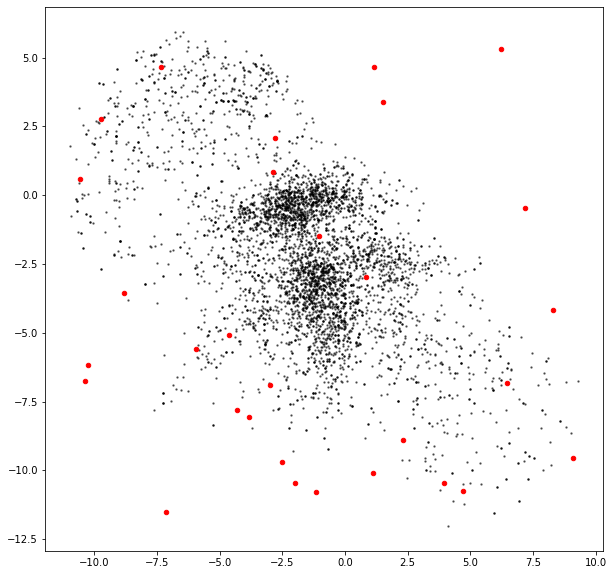

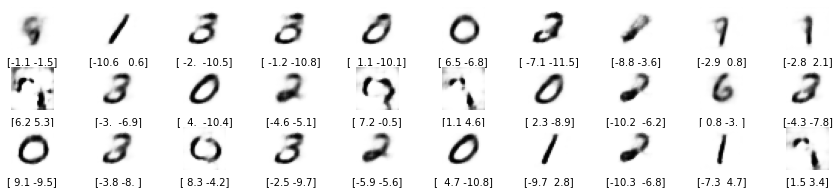

In [8]:

figsize = 10

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x, max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y, max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c='red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

## 좌표평면 상에서 생성된 이미지 보기

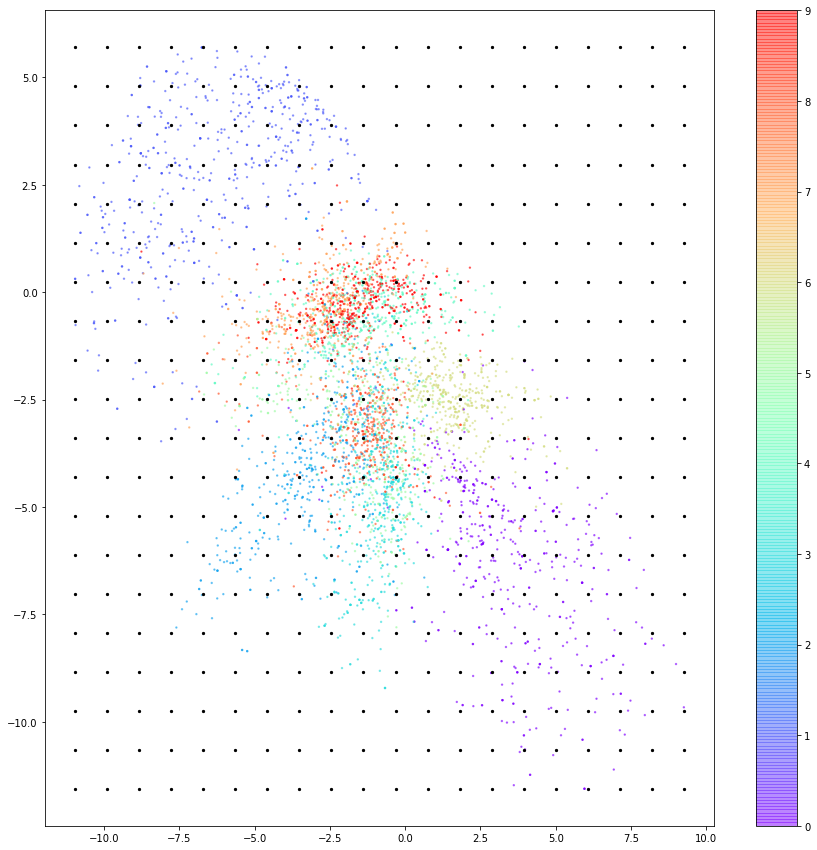

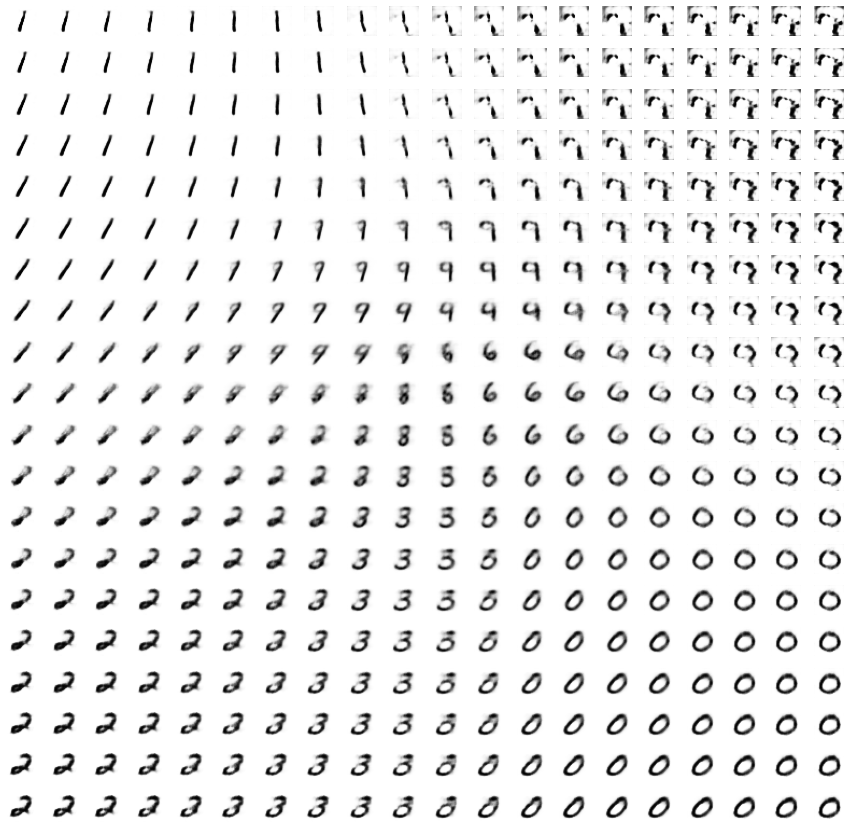

In [9]:

n_to_show = 5000
grid_size = 20

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c=example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black', alpha=1, s=5)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')